In [1]:
# Install catalax
# !pip install catalax

In [2]:
import catalax as ctx
import catalax.mcmc as cmc

# Hamiltonian Monte Carlo (HMC) Parameter Estimation

This notebook demonstrates how to use Catalax for Bayesian parameter estimation using Hamiltonian Monte Carlo (HMC) sampling. We'll work with a simple Michaelis-Menten enzyme kinetics model and estimate the parameters `v_max` and `K_m` from noisy experimental data.

## Overview
1. Define a simple enzyme kinetics model with Michaelis-Menten kinetics
2. Load and augment experimental data with realistic noise
3. Set up Bayesian priors for the parameters
4. Perform HMC sampling to estimate parameter distributions
5. Analyze and visualize the results


In [3]:
# Initialize the model
model = ctx.Model(name="Simple menten model")

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors
model.parameters.v_max.value = 7.0
model.parameters.K_m.value = 100.0

# Save the model
model.save("./models/", "menten_model")

model

,name,symbol
0,s1,s1


,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100.0,False,None,None,None,None
1,v_max,v_max,7.0,False,None,None,None,None


""



Model(
    name='Simple menten model',
    odes=DottedDict({'s1': ODE(species=Species(name='s1', symbol=s1), equation=-s1*v_max/(K_m + s1), observable=True, parameters=DottedDict({'K_m': Parameter(name='K_m', symbol=K_m, value=100.0, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, hdi=None, prior=None), 'v_max': Parameter(name='v_max', symbol=v_max, value=7.0, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, hdi=None, prior=None)}))}),
    species=,
    parameters=,
    constants=
)

/Users/janrange/GitHub/Catalax/catalax/dataset/dataset.py:789: UserWarning: The figure layout has changed to tight
  plt.tight_layout(w_pad=4, h_pad=4)


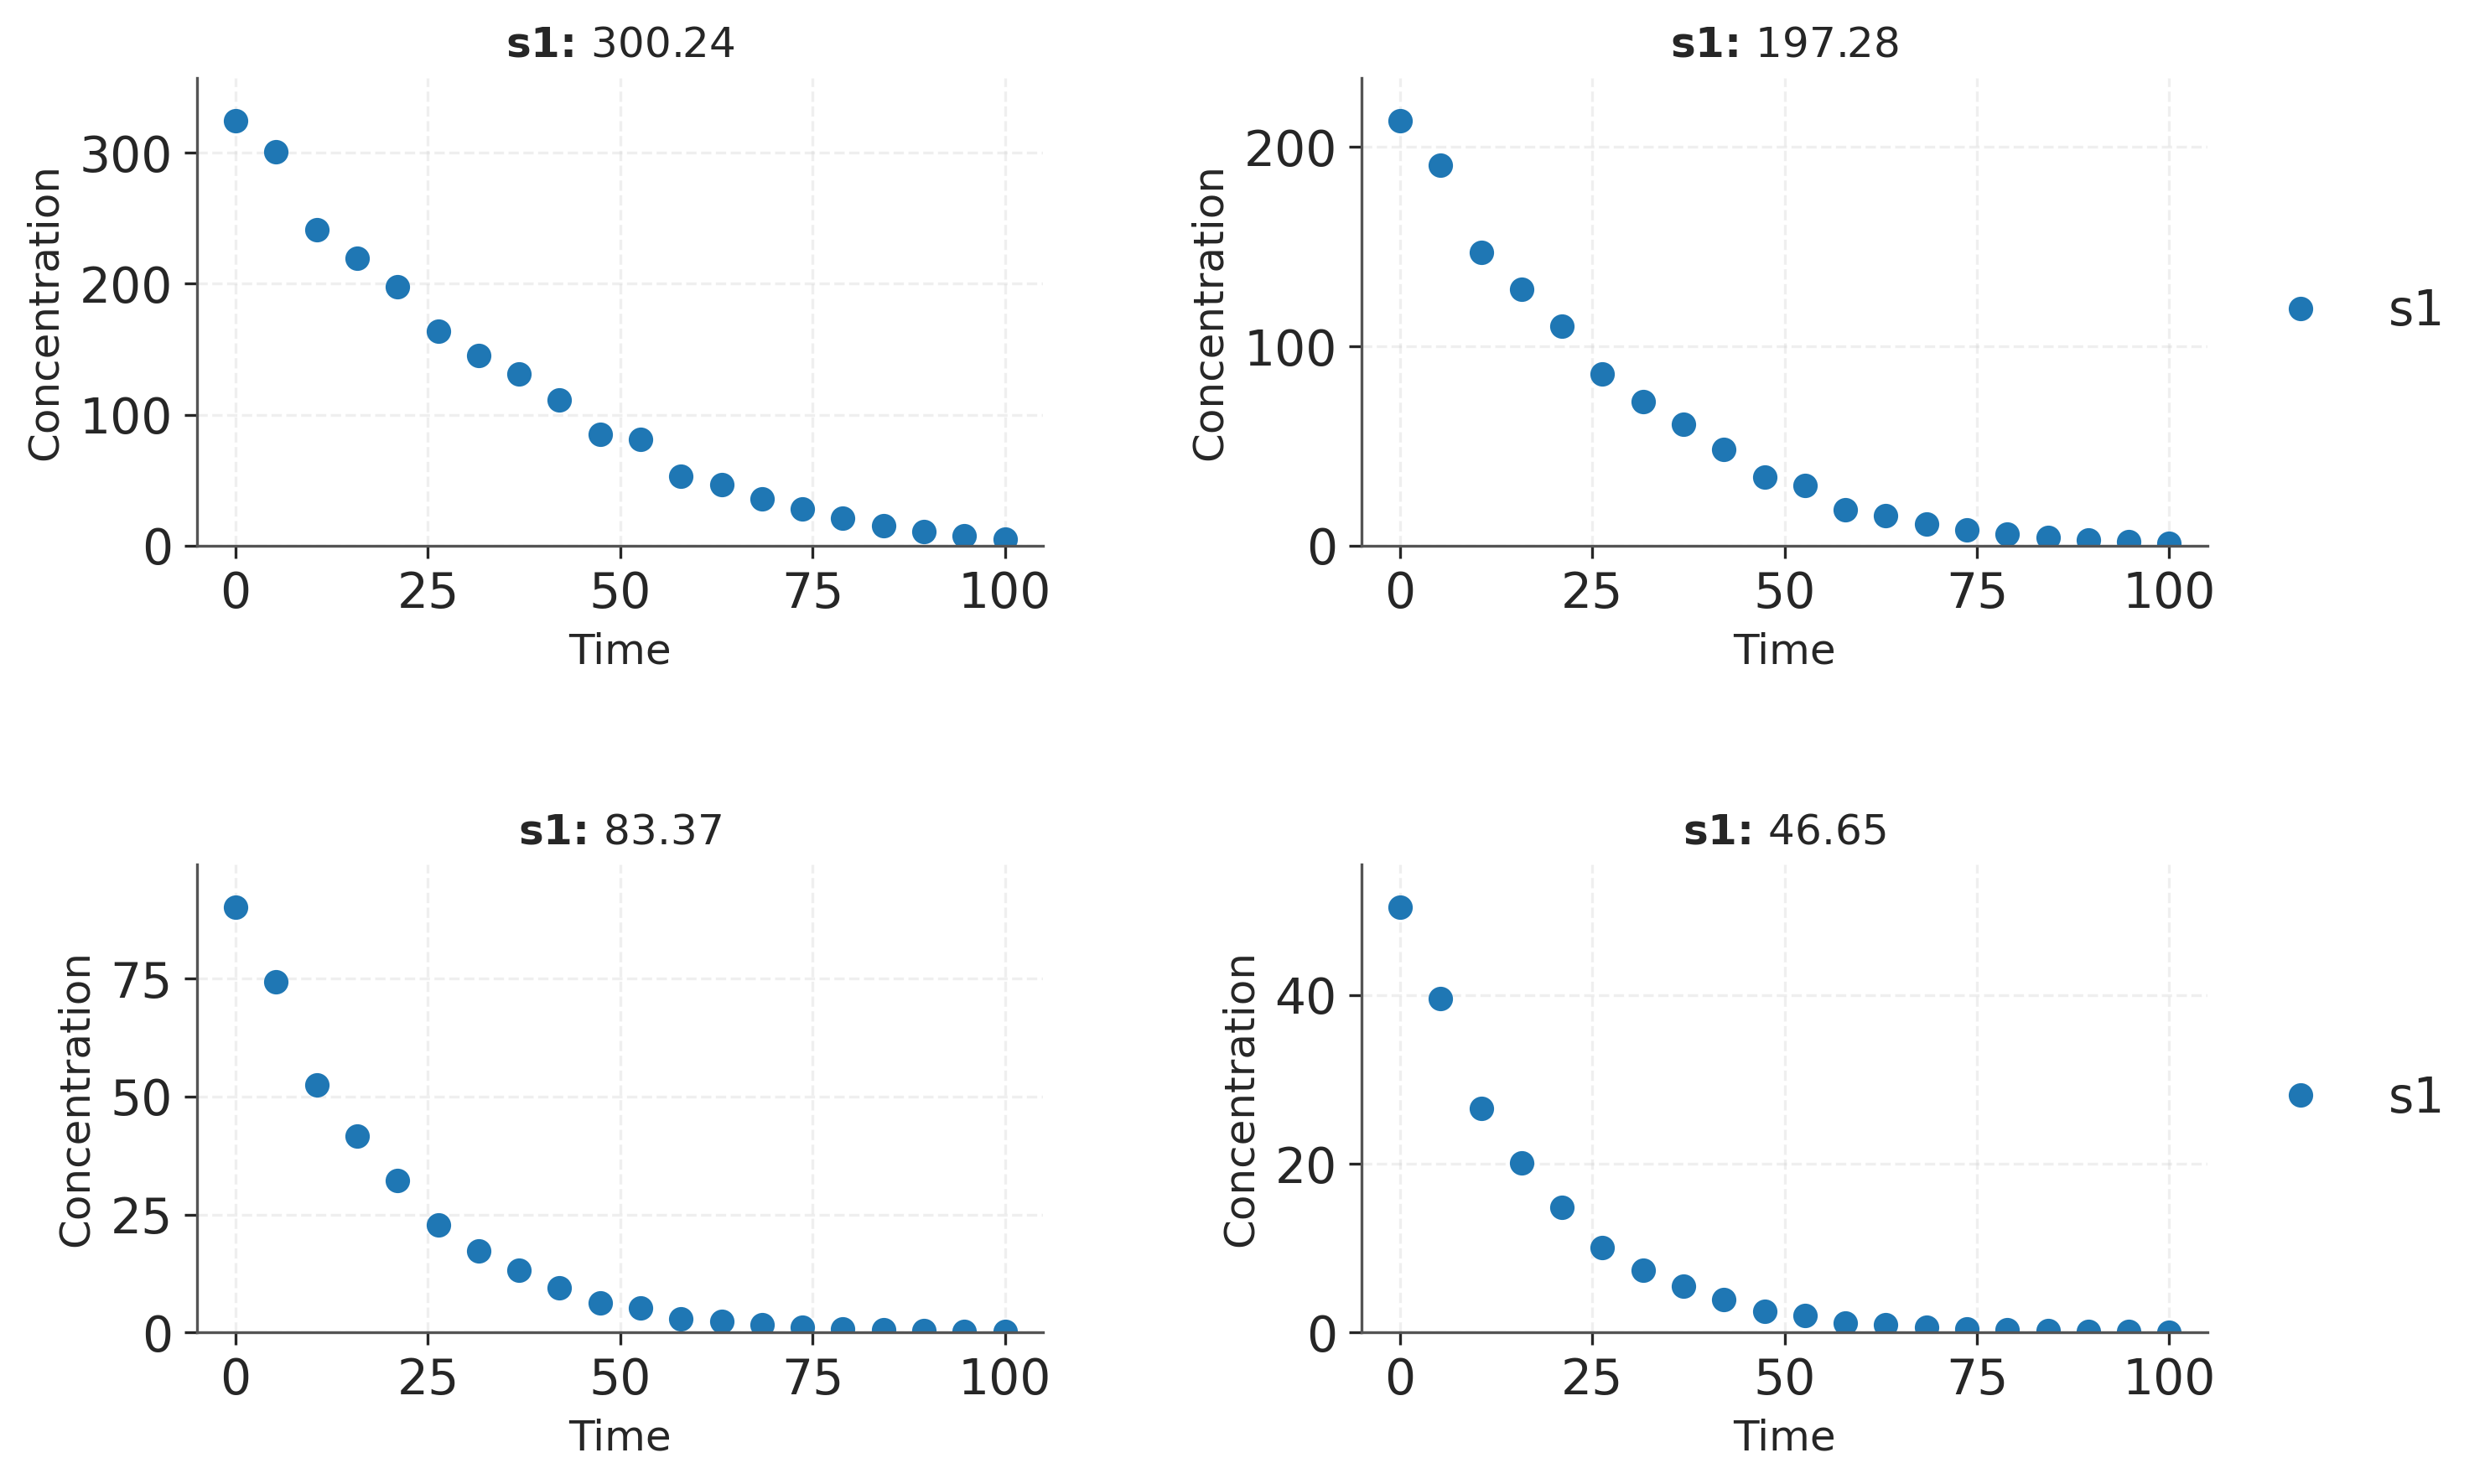

In [6]:
# Load the datasets
dataset = ctx.Dataset.from_croissant("datasets/croissant_dataset.zip")

# We need to add some noise to the data to make it more realistic
dataset = dataset.augment(
    n_augmentations=1,
    seed=0,
    sigma=5e-2,
    append=False,
    multiplicative=True,
)

f = dataset.plot(measurement_ids=[m.id for m in dataset.measurements[:4]])

In [7]:
# Define Priors
model.parameters.v_max.prior = cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.K_m.prior = cmc.priors.Uniform(low=1e-6, high=1e3)

model.parameters.v_max.prior

# Save the model and its priors
model.save("./models/", "menten_model_w_priors")

In [8]:
# Perform MCMC simulation
config = cmc.MCMCConfig(
    num_warmup=1000,
    num_samples=1000,
    dt0=0.1,
    max_steps=64**4,
)

mcmc, bayes_model = cmc.run_mcmc(
    model=model,
    dataset=dataset,
    yerrs=2.0,
    config=config,
)


🚀 Running MCMC



sample: 100%|██████████| 2000/2000 [01:34<00:00, 21.16it/s, 9 steps of size 2.96e-01. acc. prob=0.94] 




🎉 Finished

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       K_m    102.74      1.08    102.72    101.02    104.53    467.26      1.00
     sigma      2.15      0.04      2.15      2.09      2.22    639.57      1.00
     v_max      7.08      0.04      7.08      7.02      7.14    461.67      1.00

Number of divergences: 0


In [9]:
# Add parameters to the model
for param, samples in mcmc.get_samples().items():
    if param not in model.parameters:
        continue

    model.parameters[param].value = float(samples.mean())

model.parameters

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,102.740929,False,None,None,None,None
1,v_max,v_max,7.082947,False,None,None,None,None


<class 'catalax.model.utils.PrettyDict'>.__repr__ returned empty string

/Users/janrange/anaconda3/envs/catalax/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
/Users/janrange/GitHub/Catalax/catalax/mcmc/plotting.py:40: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


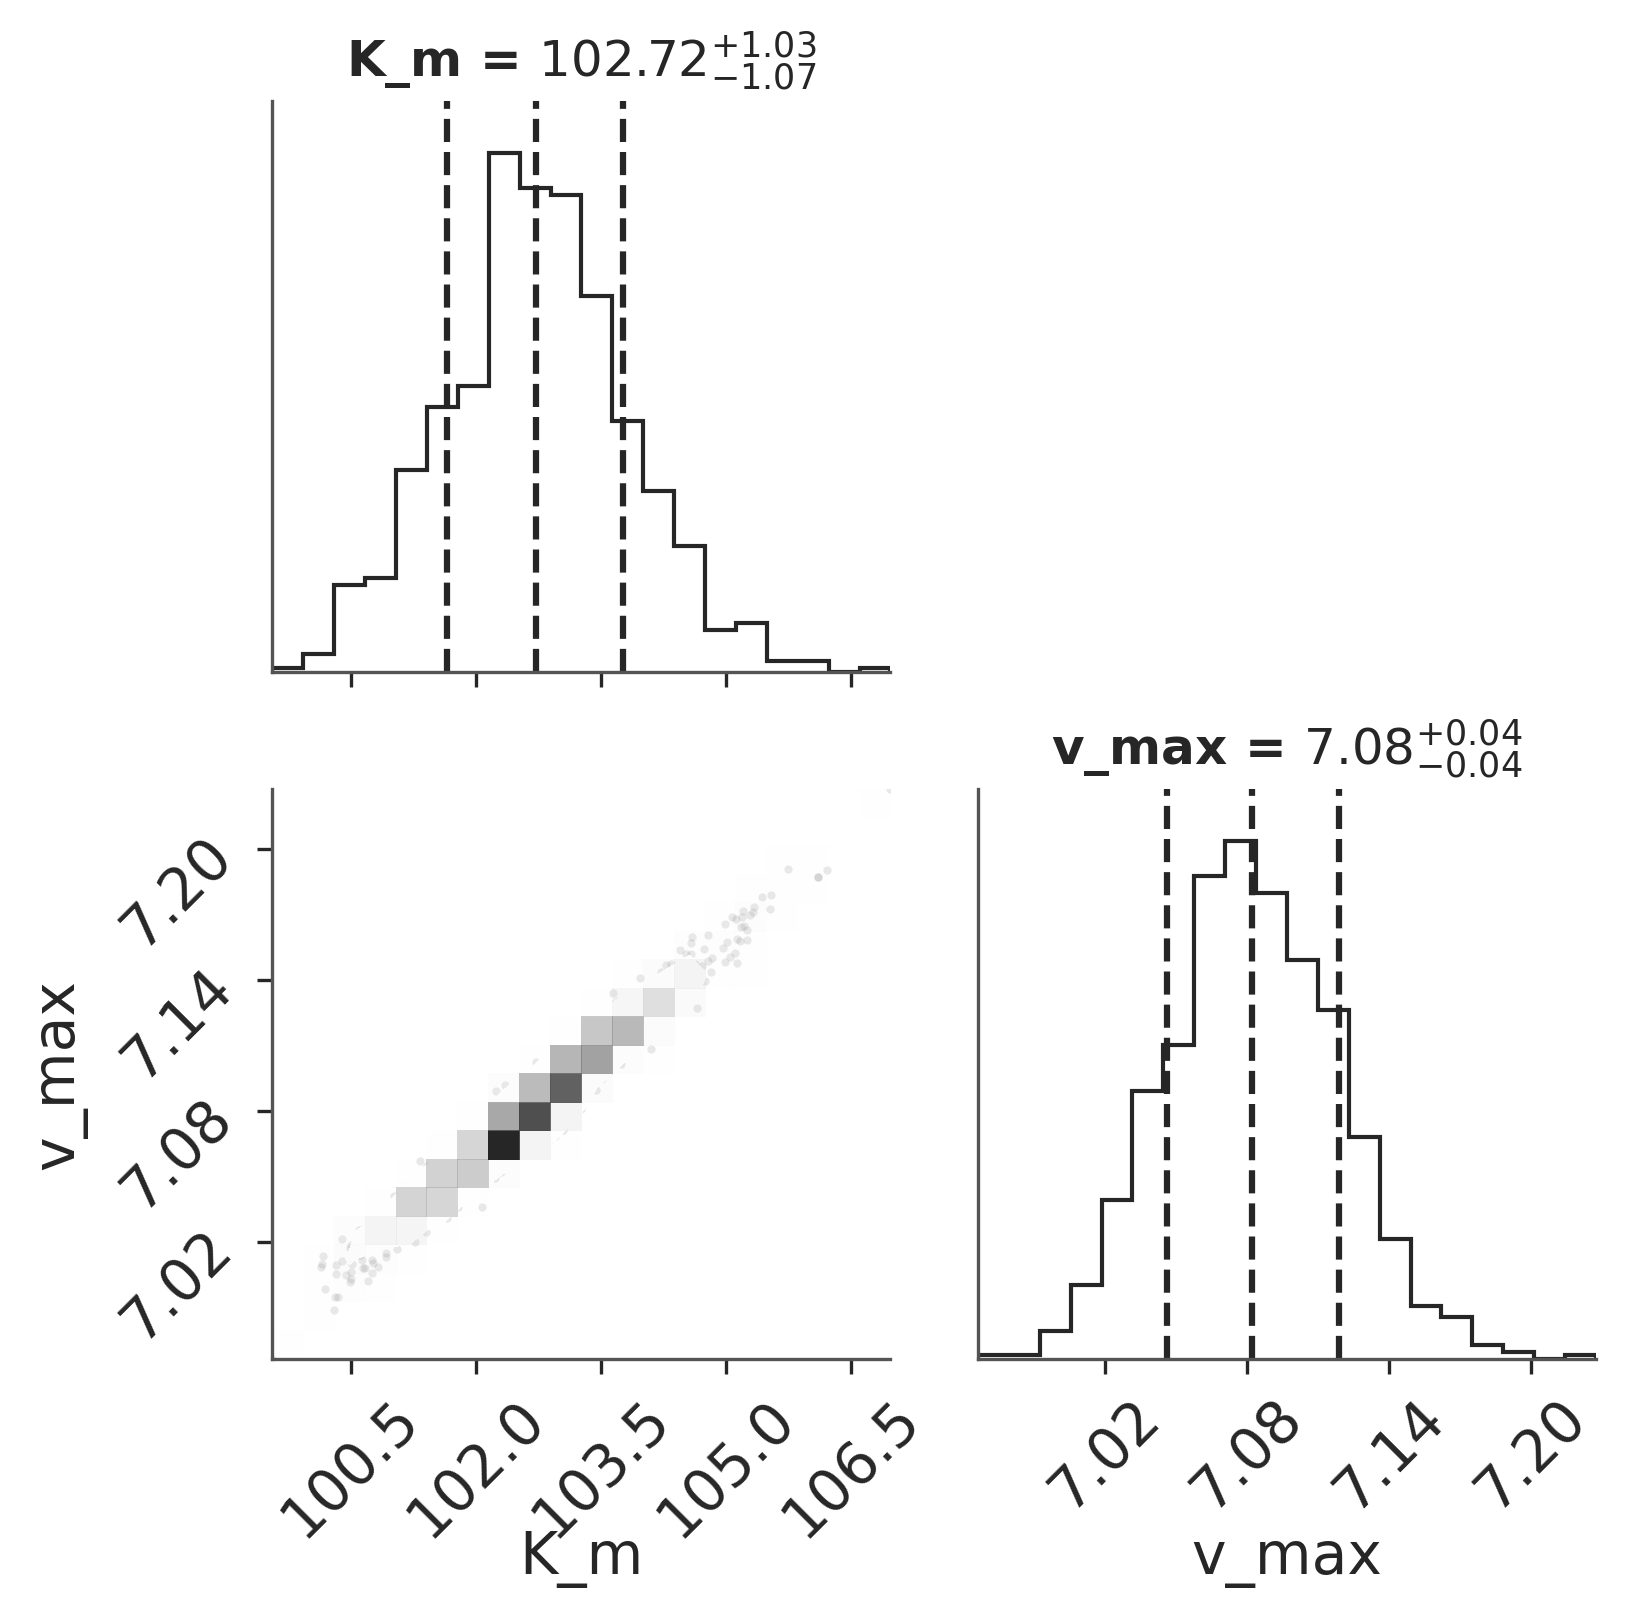

In [10]:
# Visualize the result using a corner plot
# Shows the posterior distribution of the parameters
# Shows the correlation between the parameters
fig = cmc.plot_corner(mcmc)

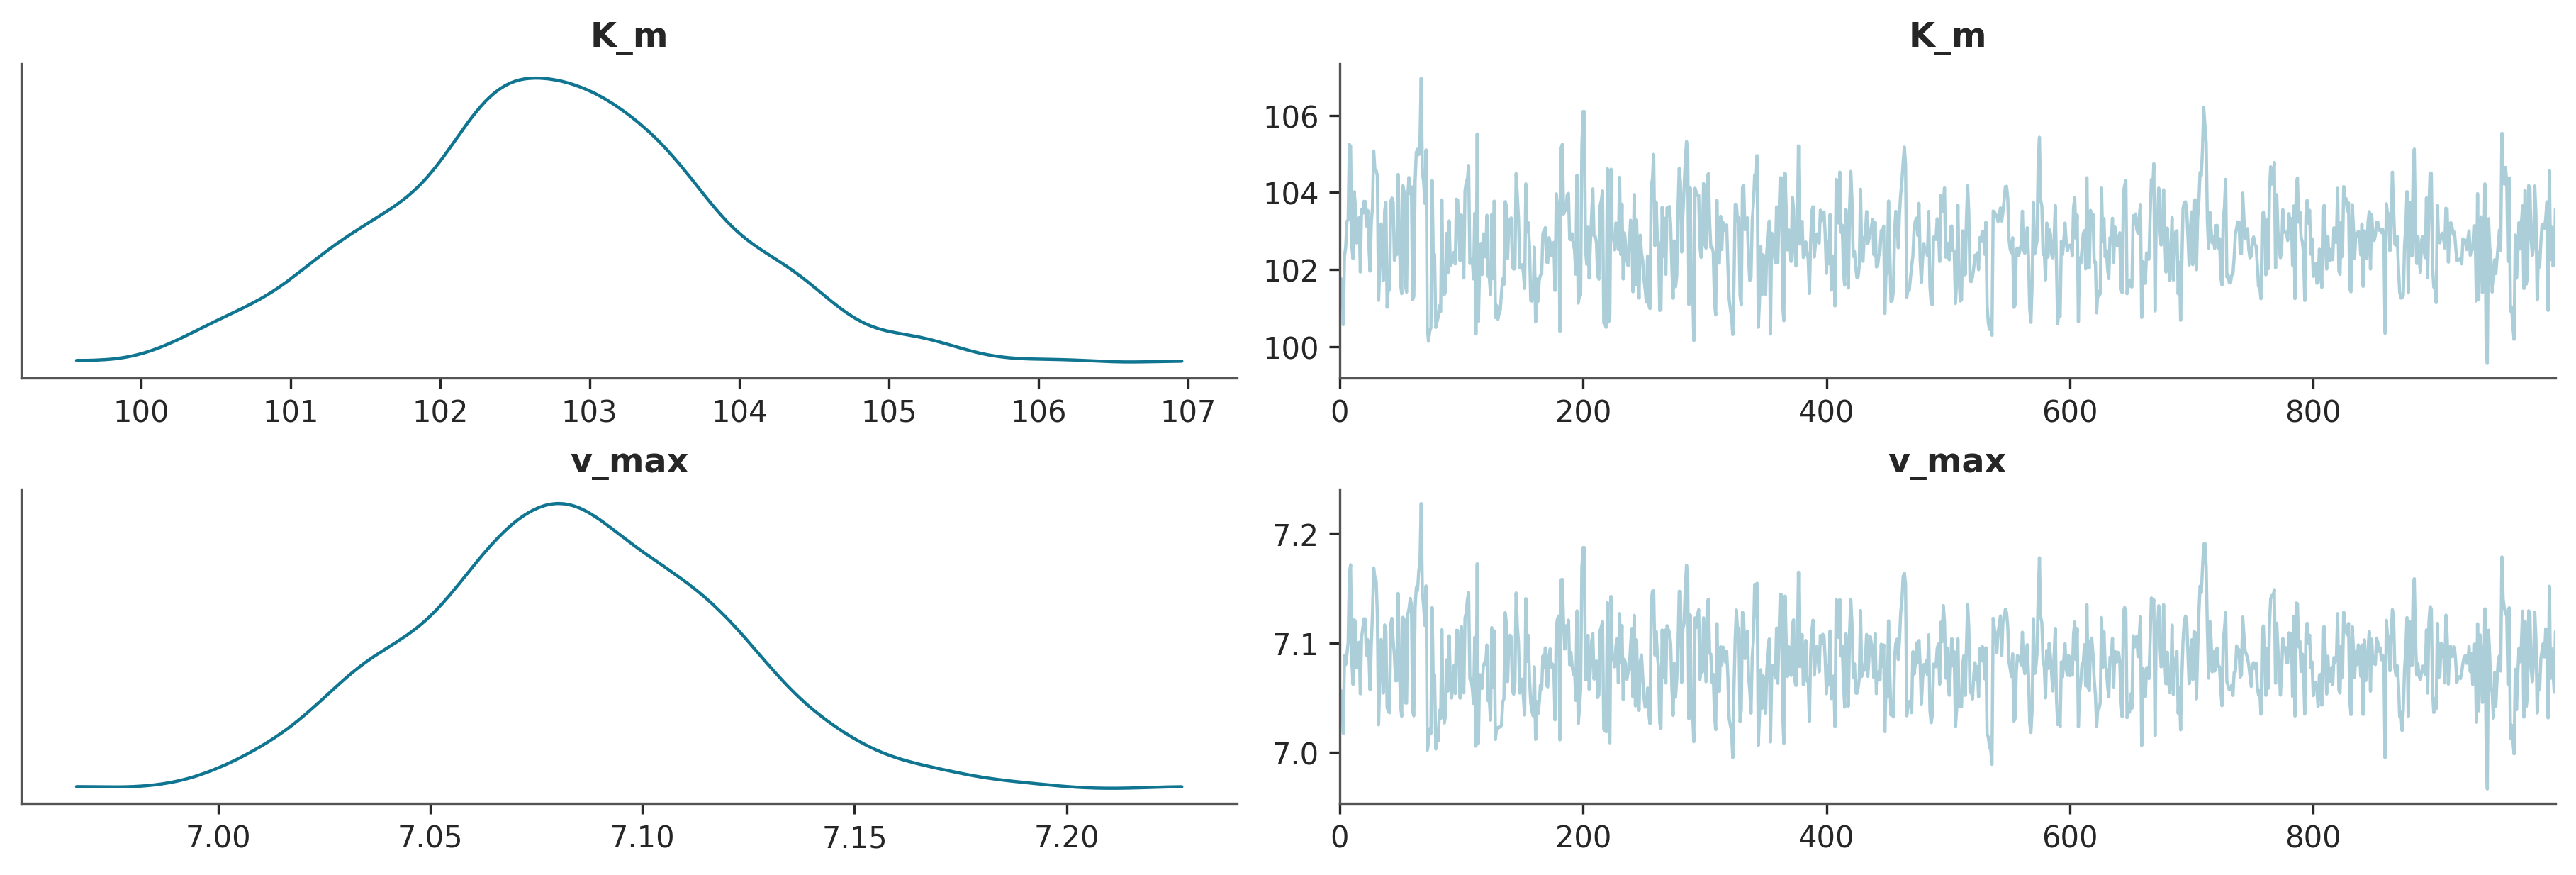

In [11]:
# Plot the trace of the MCMC (Posterior dist and chain trace)
f = cmc.plot_trace(mcmc, model)

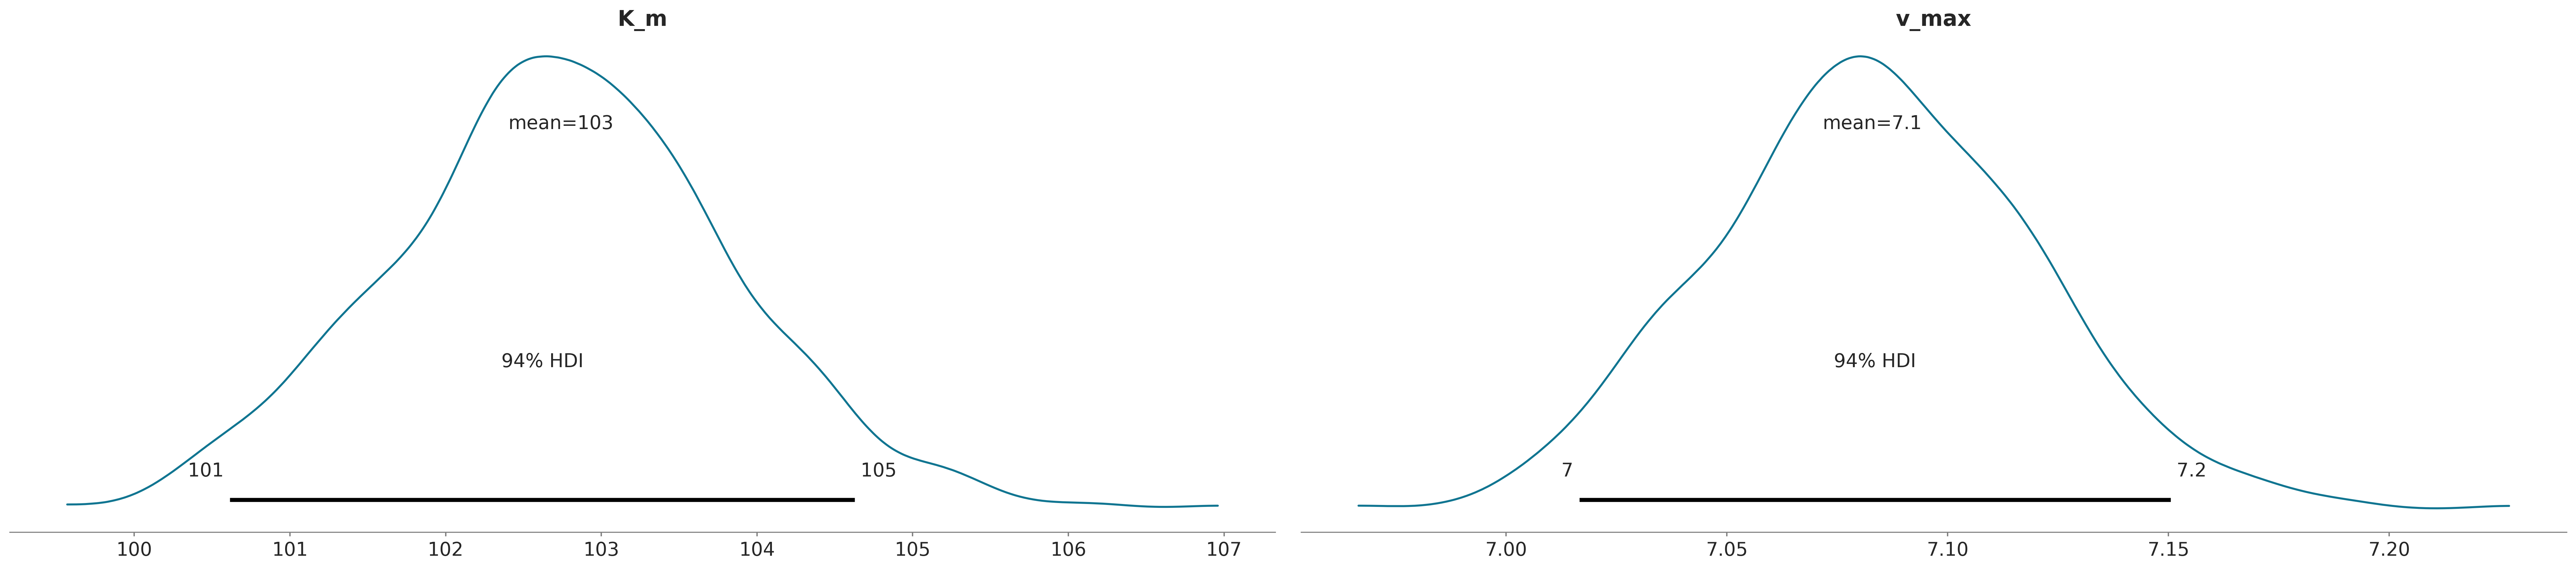

In [12]:
# Variant of plotting the posterior with HDPI
f = cmc.plot_posterior(mcmc, model)

/Users/janrange/GitHub/Catalax/catalax/dataset/dataset.py:789: UserWarning: The figure layout has changed to tight
  plt.tight_layout(w_pad=4, h_pad=4)


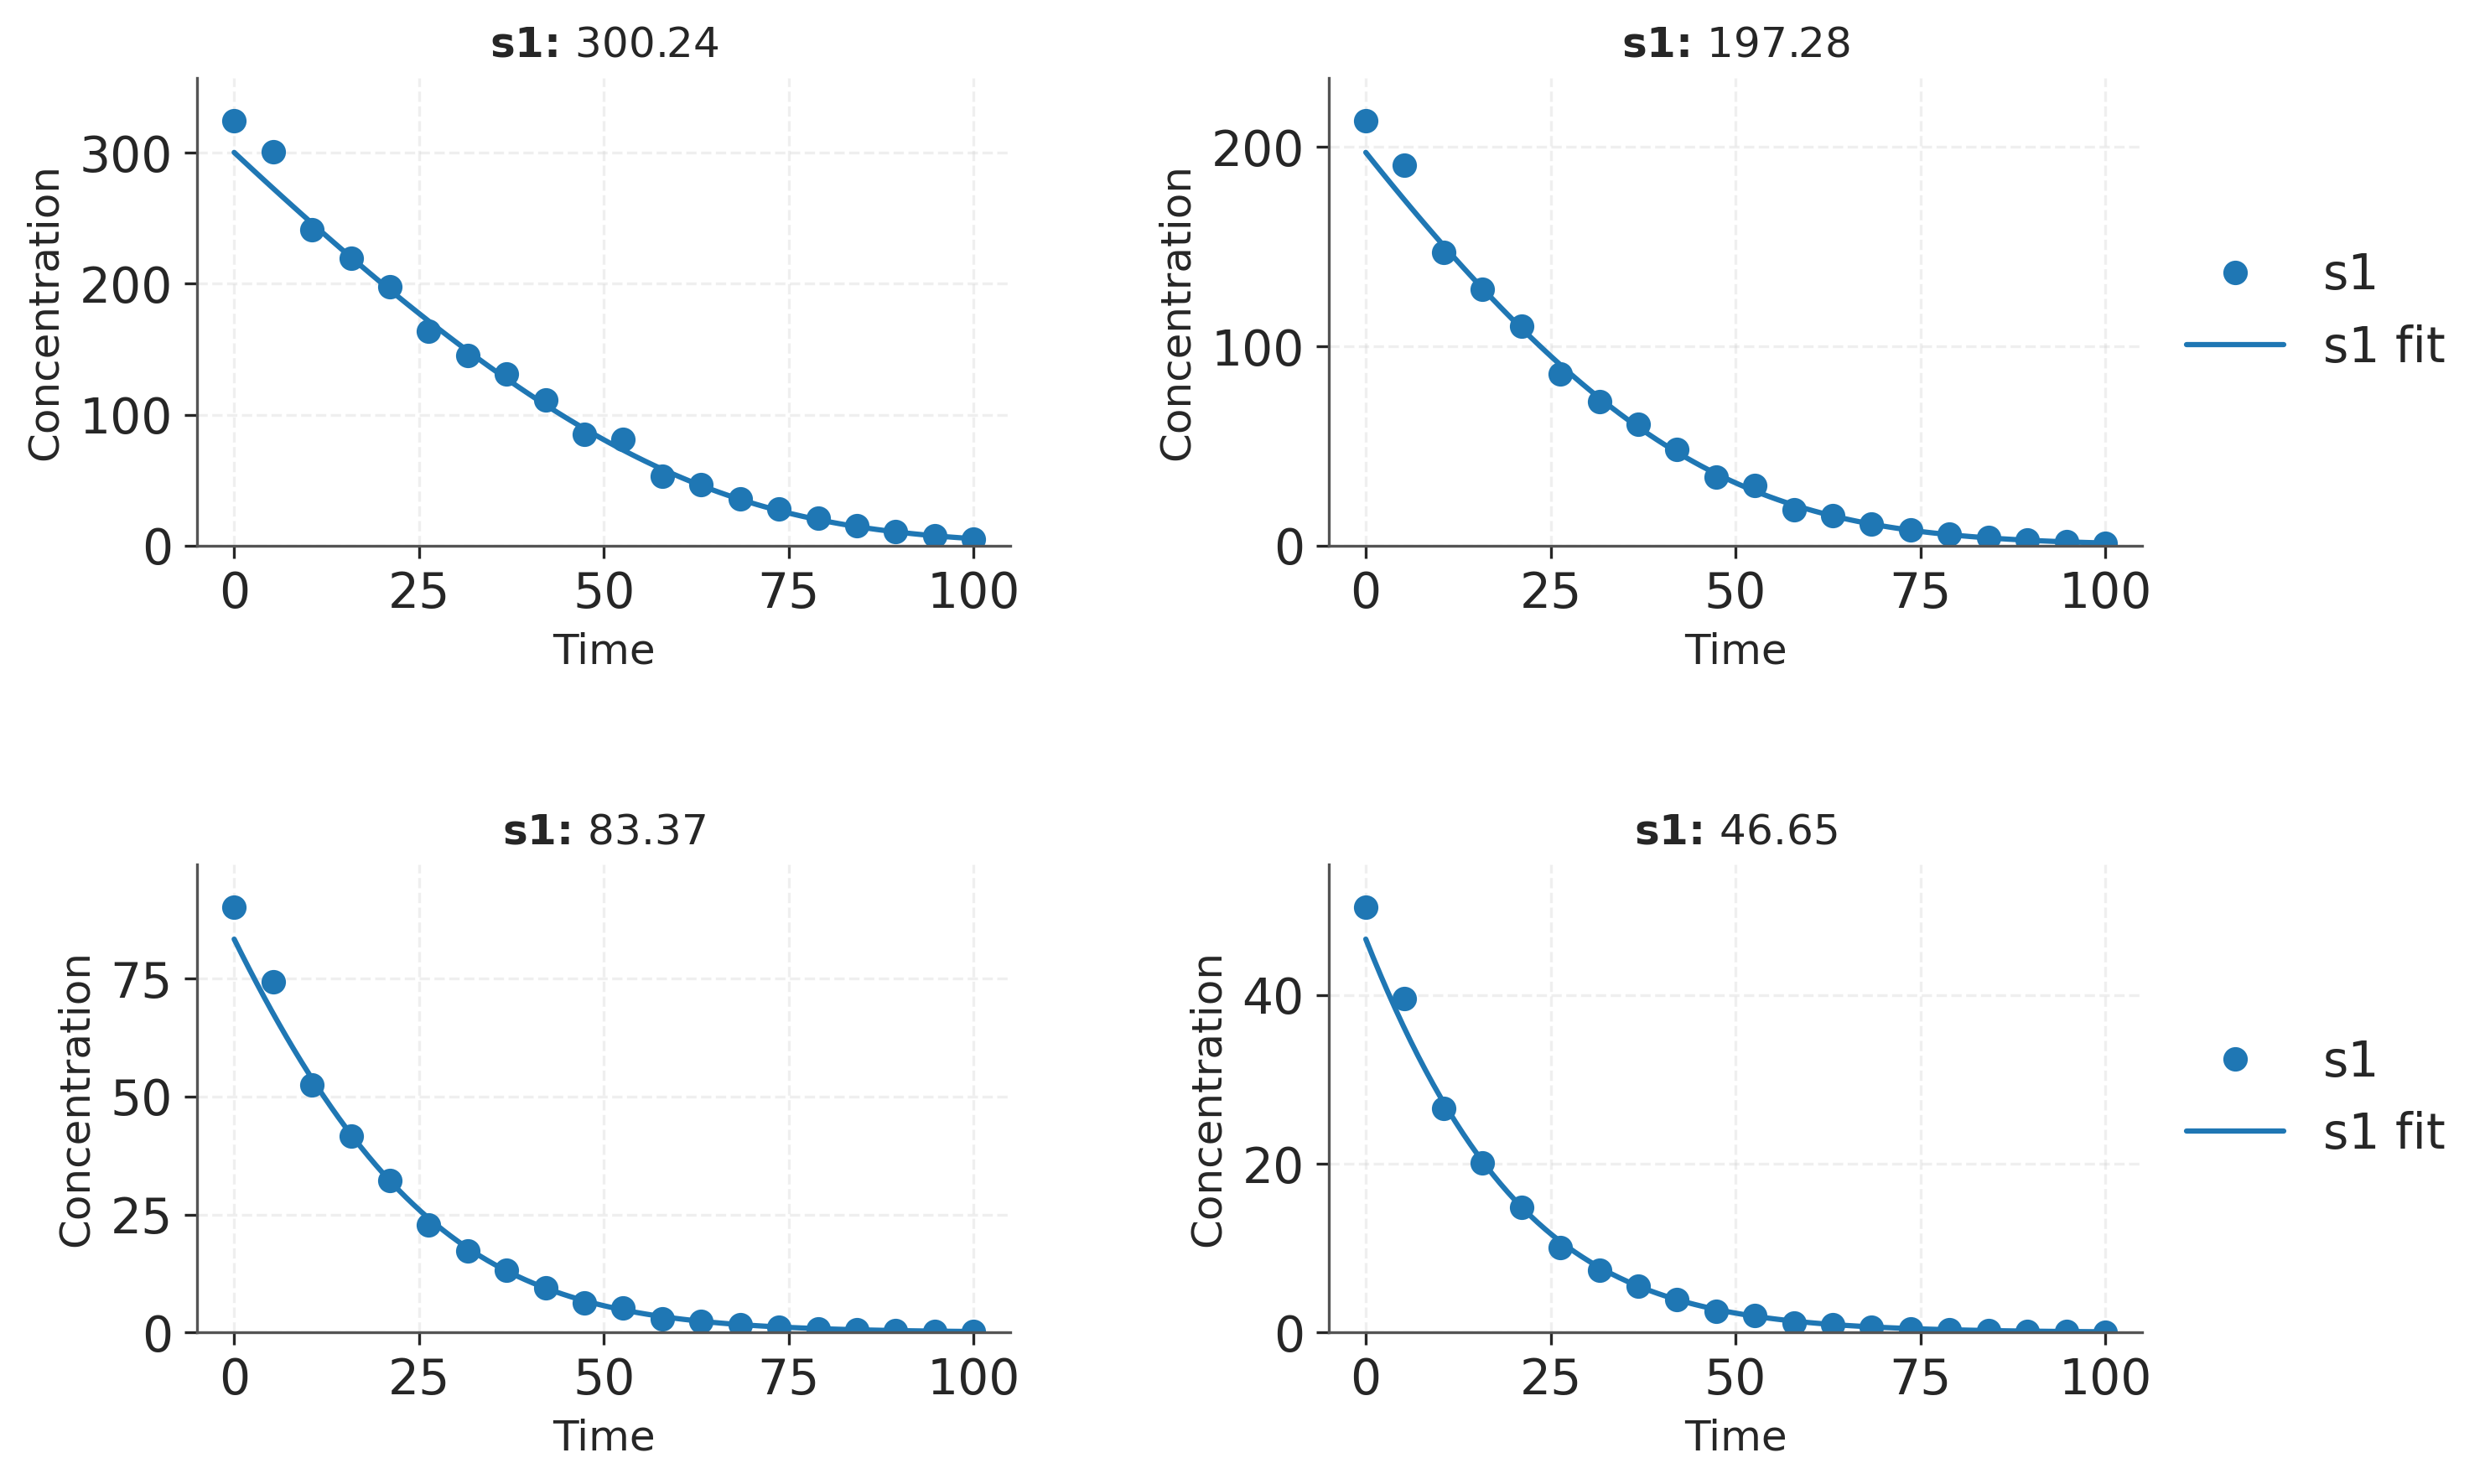

In [17]:
# Visualize fit of MCMC to data
#
# When an mcmc object is passed to visualize, the fit is plotted
# including the 90% highest posterior density interval (HPDI) of
# the parameters and thus the uncertainty of the fit.
#
# In order to see the effects, change the line in the beginning
# to the following:
#
#      data = np.random.normal(data, 15.0).clip(min=0)
#
# This will add some noise to the data and the fit will be less
# certain and the HPDI will be wider.


f = dataset.plot(
    predictor=model,
    measurement_ids=[m.id for m in dataset.measurements[:4]],
    show=False,
)